In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import numpy as np
import warnings
import os

warnings.filterwarnings('ignore')

In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive')

with zipfile.ZipFile('/content/drive/MyDrive/PlantVillage-20250418T191316Z-001.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/PlantVillage2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "!unzip "/content/drive/MyDrive/PlantVillage-20250418T191316Z-001.zip" -d "/content/drive/MyDrive/PlantVillage"

/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [ ]:

dataset_path = "/content/drive/MyDrive/PlantVillage2/PlantVillage"

imagesize = 256
batchsize = 32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(imagesize, imagesize),
    batch_size=batchsize
)

class_names = dataset.class_names
print("Classes:", class_names)

Found 2152 files belonging to 3 classes.
Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [ ]:
class_names = dataset.class_names
print("Classes:", class_names)

Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


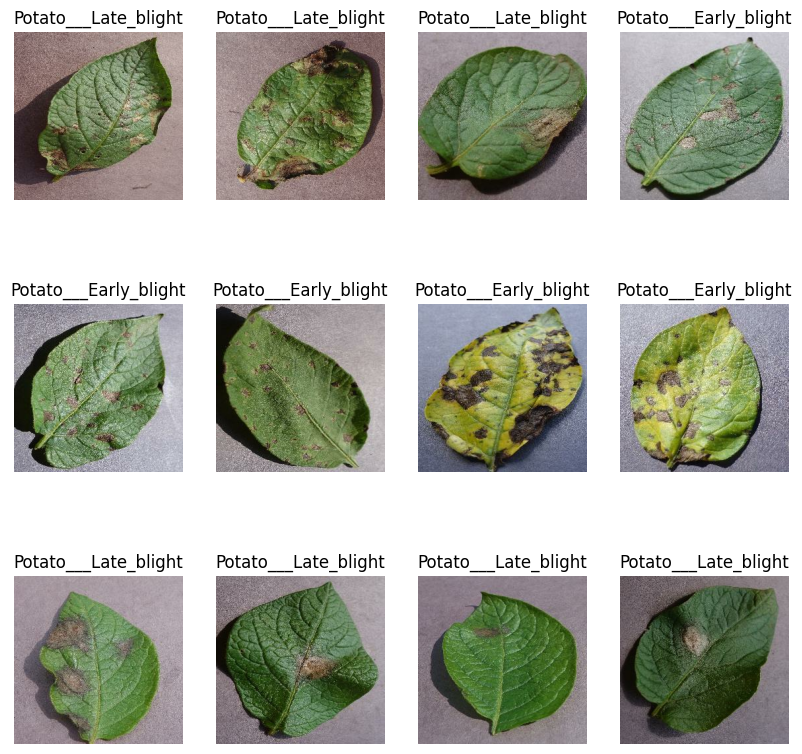

In [ ]:
import matplotlib.pyplot as plt
for image_batch, labels_batch in dataset.take(1):
 plt.figure(figsize=(10, 10))
 for i in range(12):
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  plt.title(class_names[labels_batch[i]])
  plt.axis("off")

In [ ]:
def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1):
 dataset_size = len(dataset)
 train_size = int(train_ratio * dataset_size)
 val_size = int(val_ratio * dataset_size)
 test_size = dataset_size - train_size - val_size

 train_ds = dataset.take(train_size)
 val_ds = dataset.skip(train_size).take(val_size)
 test_ds = dataset.skip(train_size + val_size)

 return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = split_dataset(dataset)
print(f"Train size: {len(train_ds)}, Validation size: {len(val_ds)}, Test size: {len(test_ds)}")

Train size: 54, Validation size: 6, Test size: 8


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(imagesize, imagesize),
    layers.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2)  # If this causes an error, replace with tf.image.adjust_brightness
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


In [ ]:
import os
imgsize = 64
features, labels = [], []
for image_batch, labels_batch in dataset.unbatch().take(4000):
 image = tf.image.resize(image_batch, (imgsize,imgsize)).numpy()
 features.append(image.flatten())
 labels.append(labels_batch.numpy())
features = np.array(features)
labels = np.array(labels)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

IMAGE_SIZE=256
CHANNELS=3
n_classes=3
# 1. Load the pre-trained EfficientNetB7 model:
efficientnetb7 = tf.keras.applications.EfficientNetB7(weights='imagenet', include_top=False,
                           input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# 2. Freeze the base model layers:
efficientnetb7.trainable = False

# 3. Add new classification layers on top:
x = efficientnetb7.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

# 4. Create the final model:
model = Model(inputs=efficientnetb7.input, outputs=predictions)

# 5. Compile the model:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# 6. Train the model:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

scores = model.evaluate(test_ds)
scores
model.save('efficientnetb7.h5')
print("Model saved as efficientnetb7.h5")

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 130s 990ms/step - accuracy: 0.7598 - loss: 0.5972 - val_accuracy: 0.9479 - val_loss: 0.1270
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 621ms/step - accuracy: 0.9652 - loss: 0.1036 - val_accuracy: 0.9427 - val_loss: 0.1215
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 658ms/step - accuracy: 0.9732 - loss: 0.0711 - val_accuracy: 0.9740 - val_loss: 0.0672
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 608ms/step - accuracy: 0.9776 - loss: 0.0696 - val_accuracy: 0.9531 - val_loss: 0.1164
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 623ms/step - accuracy: 0.9856 - loss: 0.0424 - val_accuracy: 0.9323 - val_loss: 0.1595
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 609ms/step - accuracy: 0.9851 - loss: 0.0376 - val_accuracy: 0.9740 - val_loss: 0.0664
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 654ms/step - accuracy: 0.9820 - loss: 0.0494 - val_accuracy: 0.9531 - val_loss: 0.0828
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 627ms/step - accuracy: 0.9821 - loss: 0.0376 - val_acc

Model saved as efficientnetb7.h5


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [ ]:
def plot_training_history(history, title='Model Performance'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'g', label='Train Acc')
    plt.plot(epochs, val_acc, 'b', label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Train Loss')
    plt.plot(epochs, val_loss, 'orange', label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

In [ ]:
def plot_confusion_matrix(model, dataset, class_names):
    y_true, y_pred = [], []

    for images, labels in dataset:
        preds = model.predict(images)
        preds = np.argmax(preds, axis=1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    print("\n Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

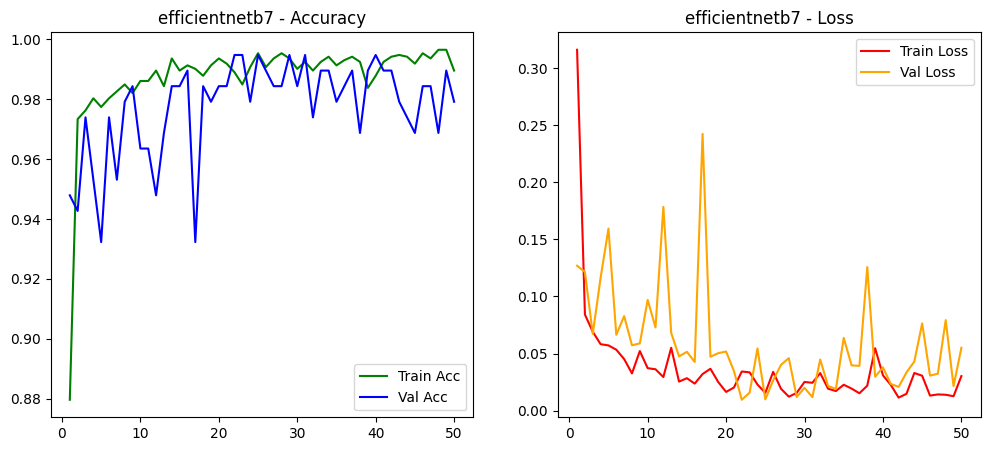

In [ ]:
class_names = ["Early Blight", "Late Blight", "Healthy"]
plot_training_history(history, title="efficientnetb7")

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


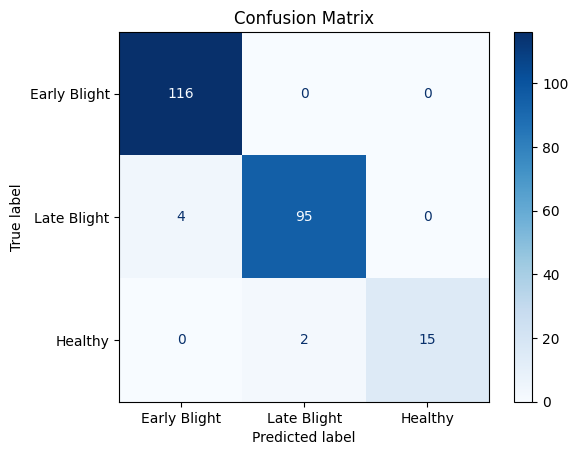


 Classification Report:
              precision    recall  f1-score   support

Early Blight       0.97      1.00      0.98       116
 Late Blight       0.98      0.96      0.97        99
     Healthy       1.00      0.88      0.94        17

    accuracy                           0.97       232
   macro avg       0.98      0.95      0.96       232
weighted avg       0.97      0.97      0.97       232

Accuracy:  0.9741
Precision: 0.9745
Recall:    0.9741
F1 Score:  0.9739


In [ ]:
plot_confusion_matrix(model, test_ds, class_names)

In [ ]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

model = load_model('/content/efficientnetb7.h5')


class_names = ["Early Blight", "Late Blight", "Healthy"]

def load_and_preprocess_image(path, target_size=(256, 256)):
    image = Image.open(path).convert('RGB')
    image = image.resize(target_size)
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


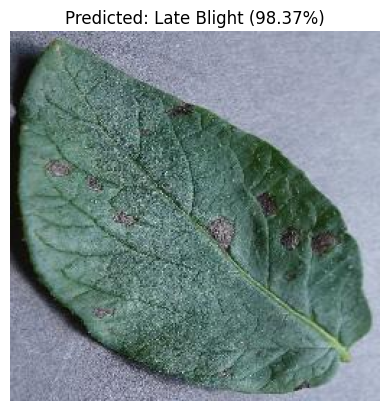

In [57]:
image_path = "/content/PotatoEarlyBlight(1).JPG"
img_array, original_image = load_and_preprocess_image(image_path)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
confidence = np.max(predictions)

plt.imshow(original_image)
plt.axis('off')
plt.title(f"Predicted: {class_names[predicted_class]} ({confidence*100:.2f}%)")
plt.show()